# WikiHades dataset


## Data prep

In [1]:
!gdown --id 1dM8gWCwh0UABV5I42xLNeFuxGK8zOuVB -O Wiki-Hades.zip
!unzip Wiki-Hades.zip && rm Wiki-Hades.zip

Downloading...
From: https://drive.google.com/uc?id=1dM8gWCwh0UABV5I42xLNeFuxGK8zOuVB
To: /content/Wiki-Hades.zip
100% 3.69M/3.69M [00:00<00:00, 198MB/s]
Archive:  Wiki-Hades.zip
   creating: Wiki-Hades/
  inflating: Wiki-Hades/train.txt    
  inflating: Wiki-Hades/valid.txt    
  inflating: Wiki-Hades/readme.txt   
  inflating: __MACOSX/Wiki-Hades/._readme.txt  
  inflating: Wiki-Hades/test.txt     


In [2]:
import gdown


datafiles = {
    "hades_train_thresh0.01.tsv": "1S4aVXl--HVyAIrX3vRbSfElPwGPX_-9E",
    "hades_train_thresh0.05.tsv": "1jpT4bXbT6kRNDVlHlsvdF8Gd-UmQNo9T",
    "hades_train_thresh0.15.tsv": "1j0Di7YoEyoDO6xq4FCiTnIS5yaNvkamn",
    "hades_train_thresh0.25.tsv": "1aJTZF9a7FVHBiSisC2ELUa4m-J4QefjN",
    "hades_train_ripser.tsv"    : "1O7jfkUNVMNJabwXGxQ01Jyw-TAth2GcU", 
    "hades_valid_thresh0.01.tsv": "1C0LFU81i4wLre7pSFra_v8S9oKx4ya9v",
    "hades_valid_thresh0.05.tsv": "14XMKuSc_PIU5qONkjymNIfF44SsMLVEe",
    "hades_valid_thresh0.15.tsv": "16RWIiUzMUtOW0mKvr8kw_5xlmmgttZHD",
    "hades_valid_thresh0.25.tsv": "1q2gbEwNxcnT-OU3kFQYMe9AuxrXrV_5e",
    "hades_valid_ripser.tsv"    : "1Ongg8jL0uYlLLEMgnCKUU8Lm8OQNm3zJ",
    "hades_test_thresh0.01.tsv" : "1dJk2hKgHoNA75vTRy4kexSl9fVz5JFue",
    "hades_test_thresh0.05.tsv" : "1897N6kK8TBYGWy6XtdJ8iGO_chhWajlD",
    "hades_test_thresh0.15.tsv" : "1nHj-St3n5uwQ7lACWAvgq3-MSN6ZGEaT",
    "hades_test_thresh0.25.tsv" : "1LMCVMeuyCH4SN-qq7NCkaQSIqdILKmCP",
    "hades_test_ripser.tsv"     : "1jKxcfmMzRiBl2_QWRYP2svfItgYs6sPb",
}

for filename, file_gid in datafiles.items():
    if filename.endswith("train_ripser.tsv"):  # gdrive broke large file downloads
        gdown.download(
            url=f"https://drive.google.com/uc?export=download&confirm=t&id={file_gid}",
            output=filename, 
            quiet=True
        )
        continue

    gdown.download(id=file_gid, output=filename, quiet=True)

## Utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
TAB_COLORS = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

FEAT_TYPES = [
    "thresh0.01",
    "thresh0.05",
    "thresh0.15",
    "thresh0.25",
    "ripser",
]

In [5]:
import json
import linecache


def load_hades(data_split, feat_type):
    assert data_split in ["train", "valid", "test"], f"Invalid data split: {data_split}"

    X = pd.read_csv(f"./hades_{data_split}_{feat_type}.tsv", sep="\t", index_col=0)

    data_path = f"./Wiki-Hades/{data_split}.txt"
    y = []
    for line_idx in X.index:
        line = linecache.getline(data_path, line_idx + 1)
        data = json.loads(line)
        y.append(data["hallucination"])

    y = pd.Series(data=y, index=X.index, name="target")
    return X, y

In [6]:
def remove_redundant_columns(*args):
    redundant_cols = args[0].columns[args[0].nunique() == 1]

    return [
        X.drop(redundant_cols, axis=1) for X in args
    ]

## Visualize

In [15]:
def show_2d_scatterplot(X, y, labels=None):
    if labels is None:
        labels = ["normal", "hallucination"]

    n_classes = len(np.unique(y))

    assert len(labels) == n_classes, "Incorrect number of labels"

    colors = TAB_COLORS[:n_classes]
    for i, (cls_name, clr) in enumerate(zip(labels, colors)):
        plt.scatter(
            X[y == i, 0], X[y == i, 1], 
            c=np.full((y == i).sum(), clr), 
            alpha=0.8,
            marker="p", s=50,
            label=cls_name
        )

    plt.legend()

In [16]:
!pip install -q umap-learn

In [17]:
import warnings

from sklearn.manifold import TSNE
import umap

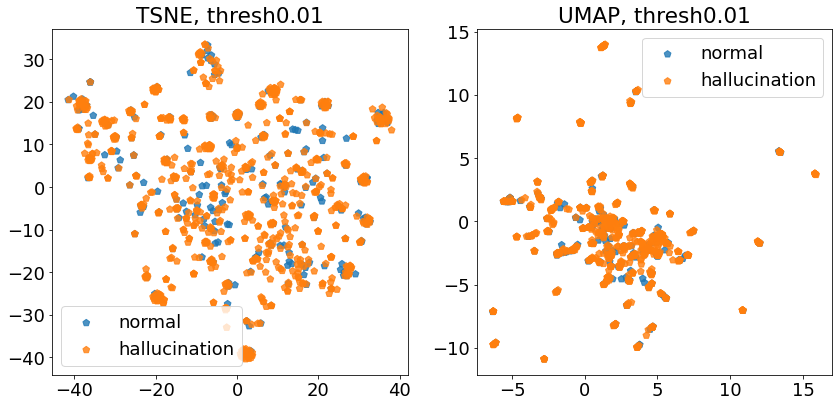

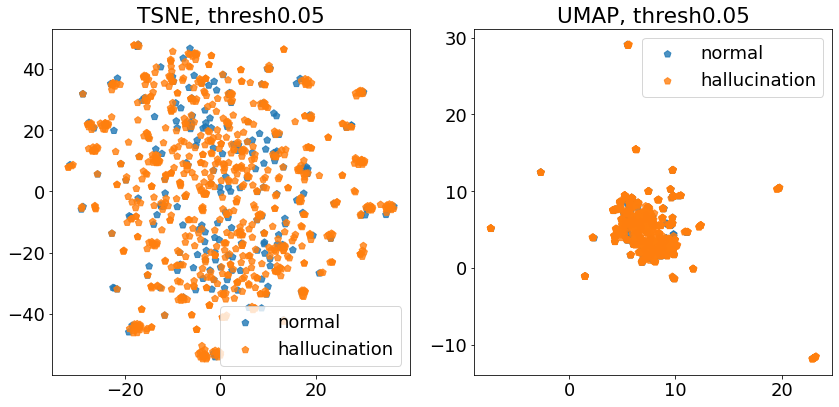

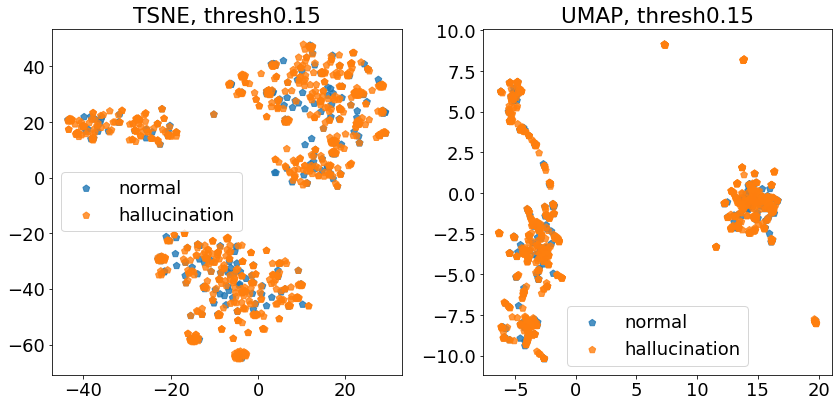

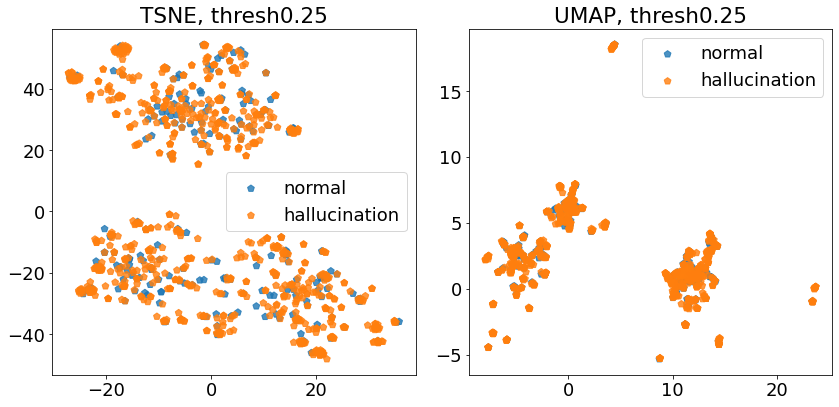

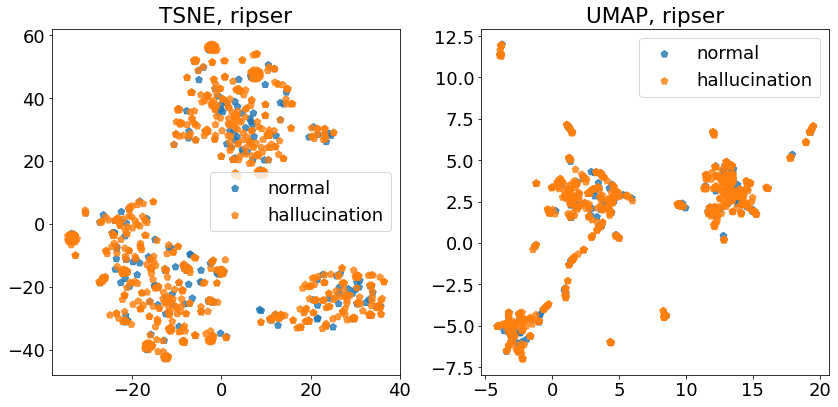

In [18]:
subset_size = 1000

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)

    for feat_type in FEAT_TYPES:
        plt.figure(figsize=(12, 6))

        X, y = load_hades("train", feat_type)

        tsne = TSNE(n_components=2)
        X_tsne = tsne.fit_transform(X[:subset_size])

        plt.subplot(121)
        show_2d_scatterplot(X_tsne, y.values[:subset_size])
        plt.gca().set_title(f"TSNE, {feat_type}")

        umap_model = umap.UMAP(n_components=2)
        X_umap = umap_model.fit_transform(X[:subset_size])

        plt.subplot(122)
        show_2d_scatterplot(X_umap, y.values[:subset_size])
        plt.gca().set_title(f"UMAP, {feat_type}")

        plt.tight_layout()
        plt.show()

In [19]:
plt.rcParams.update({"font.size": 18})

In [20]:
def plot_distributions(X, y, layer, head, bin_cnt=20):
    error_mask = y == 1
    X_good, X_bad = X[~error_mask], X[error_mask]

    lh_feats = list(filter(lambda name: name.startswith(f"l{layer}_h{head}_"), X.columns))

    plt.figure(figsize=(len(lh_feats) * 6, 6))

    for i, lh_feat in enumerate(lh_feats):
        ax = plt.subplot(1, len(lh_feats), i + 1)
        _, bins = np.histogram(X[lh_feat], bins=bin_cnt)
        plt.hist(X_good[lh_feat], bins, alpha=0.5, color="b", label="normal", density=True)
        plt.hist(X_bad[lh_feat], bins, alpha=0.5, color="r", label="hallucination", density=True)
        ax.legend()
        ax.set_title(lh_feat)

    plt.tight_layout()

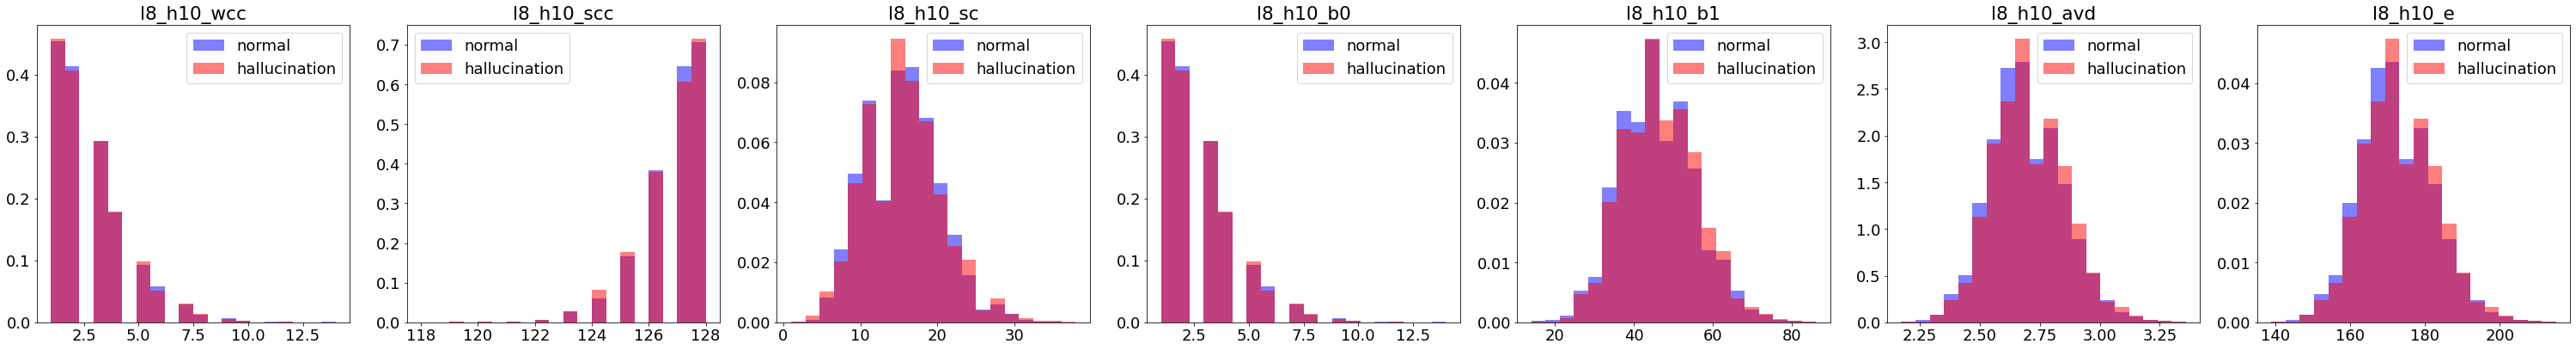

In [21]:
X, y = load_hades("train", "thresh0.15")

plot_distributions(X, y, layer=8, head=10)

plt.show()

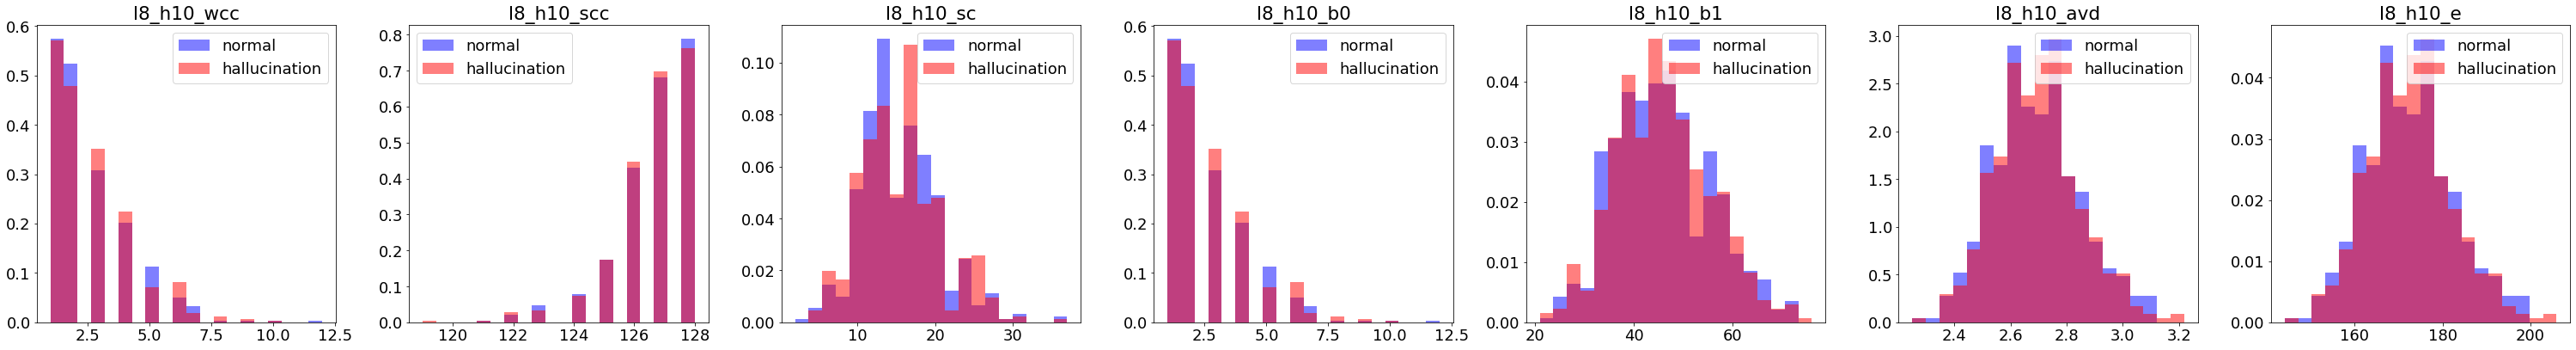

In [14]:
X, y = load_hades("valid", "thresh0.15")

plot_distributions(X, y, layer=8, head=10)

plt.show()

In [ ]:
del X, y

## Error detection

HaDes baseline:
```
Acc : 0.709
f1 : 0.7408726625111309 0.6681870011402509
precision : 0.6819672131147541 0.7512820512820513
recall : 0.8109161793372319 0.6016427104722792
G-mean : 0.6984853671214227
bss : 0.18964858912275
ROC-AUC : 0.778624350060641
```

In [ ]:
!pip3 install -q optuna mlflow

In [ ]:
SEED = 0

In [ ]:
class OptimizationObjective:

    def __init__(self, train_data, valid_data, model_cls, search_space, 
                 scoring, scoring_type="binary"):
        self.X_train, self.y_train = train_data
        self.X_valid, self.y_valid = valid_data

        self.model_cls = model_cls
        self.search_space = search_space

        assert scoring_type in ["binary", "probs"], "Invalid scoring type"
        self.scoring_type = scoring_type
        self.scoring = scoring

    def _prep_model_params(self, trial):
        model_params = dict()
        for name, params in self.search_space.items():
            suggestion_type = params[0]
            if suggestion_type == "const":
                value = params[1]
            else:
                suggest_value = getattr(trial, f"suggest_{suggestion_type}")
                value = suggest_value(name, *params[1:])

            model_params[name] = value
        
        return model_params


    def __call__(self, trial):
        model_params = self._prep_model_params(trial)

        estimator = self.model_cls(**model_params)
        estimator = estimator.fit(self.X_train, self.y_train)

        if self.scoring_type == "binary":
            valid_preds = estimator.predict(self.X_valid)
        else:
            valid_preds = estimator.predict_proba(self.X_valid)

        score = self.scoring(self.y_valid, valid_preds)
        
        return score

In [ ]:
def restore_params(optuna_best_params, search_space):
    full_params = optuna_best_params.copy()
    for name, params in search_space.items():
        if params[0] == "const":
            full_params[name] = params[1]

    return full_params

In [ ]:
import sklearn.metrics as metrics

In [ ]:
def compute_test_scores(estimator, X, y_true, epsilon=1e-8):
    scores = dict()

    y_preds = estimator.predict(X)

    scores["accuracy"] = metrics.accuracy_score(y_true, y_preds)
    for metric in ["f1", "precision", "recall"]:
        scoring_func = getattr(metrics, f"{metric}_score")
        class_scores = scoring_func(y_true, y_preds, average=None)
        scores.update(
            {f"{metric}_cls{i}": score for i, score in enumerate(class_scores)}
        )
    
    scores["gmean_recall"] = np.sqrt(
        scores["recall_cls0"] * scores["recall_cls1"]
    )

    y_probs = estimator.predict_proba(X)[:, 1]
    scores["bss"] = metrics.brier_score_loss(y_true, y_probs)
    scores["roc_auc"] = metrics.roc_auc_score(y_true, y_probs)

    return scores

In [ ]:
import optuna
from optuna.exceptions import ExperimentalWarning

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [ ]:
warnings.filterwarnings("ignore", category=ExperimentalWarning)

In [ ]:
import os
import mlflow

In [ ]:
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/no-brainer/tda-mt.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "no-brainer"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "<secret>"

In [ ]:
def select_best_hyperparams(train_data, valid_data, n_trials, search_space, model_cls, 
                            scoring_fn=metrics.accuracy_score):
    sampler = optuna.samplers.TPESampler(seed=SEED)

    study = optuna.create_study(
        sampler=sampler,
        study_name=f"HaDes hyperparam optimization", 
        direction="maximize"
    )

    objective = OptimizationObjective(train_data, valid_data, model_cls, 
                                      search_space, scoring_fn)

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study.best_params

### CatBoost

In [ ]:
!pip3 install -q catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
search_space = {
    "verbose": ("const", False),
    "iterations": ("const", 20),
    "random_seed": ("const", SEED),
    "task_type": ("const", "GPU"),
    "depth": ("int", 4, 10),
    "learning_rate": ("loguniform", 1e-3, 1.),
}

best_params = []
for feat_type in FEAT_TYPES:
    X_train, y_train = load_hades("train", feat_type)
    X_valid, y_valid = load_hades("valid", feat_type)
    X_train, X_valid = remove_redundant_columns(X_train, X_valid)
    params = select_best_hyperparams(
        (X_train, y_train),
        (X_valid, y_valid), 
        n_trials=30, 
        search_space=search_space, 
        model_cls=CatBoostClassifier
    )

    best_params.append(params)

In [48]:
boosting_scores = []

for i, feat_type in enumerate(FEAT_TYPES):
    X_train, y_train = load_hades("train", feat_type)
    X_valid, y_valid = load_hades("valid", feat_type)

    params = restore_params(best_params[i], search_space)
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    scores = dict(feature_type=feat_type)
    scores["train_scores"] = compute_test_scores(model, X_train, y_train)
    scores["valid_scores"] = compute_test_scores(model, X_valid, y_valid)
    scores["params"] = params

    scores["feature_importance"] = model.get_feature_importance(
        prettified=True
    )

    boosting_scores.append(scores)

In [52]:
for exp_data in boosting_scores:
    print(exp_data["feature_type"])
    print("train acc: {:.6f}, valid acc: {:.6f}".format(
        exp_data["train_scores"]["accuracy"], 
        exp_data["valid_scores"]["accuracy"]
    ))
    print(exp_data["feature_importance"].head(5))
    print("\n=====\n")

thresh0.01
train acc: 0.863491, valid acc: 0.533000
   Feature Id  Importances
0    l6_h2_b1     1.644467
1   l8_h7_avd     1.610208
2  l11_h11_b0     1.552166
3    l11_h6_e     1.520319
4    l6_h3_b1     1.430543

=====

thresh0.05
train acc: 0.870002, valid acc: 0.484000
   Feature Id  Importances
0   l1_h0_scc     2.040355
1  l10_h5_scc     2.014144
2   l6_h8_scc     1.899536
3  l10_h11_b0     1.738947
4    l5_h0_b0     1.645335

=====

thresh0.15
train acc: 0.915125, valid acc: 0.508000
   Feature Id  Importances
0    l8_h10_e     1.752195
1   l0_h6_scc     1.663685
2   l1_h1_avd     1.302639
3  l11_h9_wcc     1.283084
4    l2_h7_sc     1.236004

=====

thresh0.25
train acc: 0.835047, valid acc: 0.530000
  Feature Id  Importances
0  l1_h3_avd     2.409215
1  l9_h10_sc     1.990031
2   l7_h11_e     1.857438
3   l6_h0_sc     1.856481
4   l9_h0_b1     1.726567

=====

ripser
train acc: 0.743432, valid acc: 0.512000
        Feature Id  Importances
0      l3_h5_std_1     2.116591
1  l3_

In [ ]:
for exp_data in boosting_scores:
    tf_type = exp_data["feature_type"]
    if tf_type.startswith("thresh"):
        tf_type = "t" + tf_type[6:].replace(".", "")
    
    run_name = f"{tf_type}_catboost_hades-2"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("dataset", "HaDes")
        mlflow.log_param("tf_type", exp_data["feature_type"])
        mlflow.log_param("random_seed", SEED)

        mlflow.log_params(exp_data["params"])

        for metric_name, value in exp_data["train_scores"].items():
            mlflow.log_metric("train_" + metric_name, value)
        for metric_name, value in exp_data["valid_scores"].items():
            mlflow.log_metric("valid_" + metric_name, value)

### Linear Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
search_space = {
    "random_state": ("const", SEED),
    "solver": ("const", "liblinear"),
    "C": ("loguniform", 1e-3, 1e3),
    "penalty": ("categorical", ("l2", "l1")),
}

best_params = []
for feat_type in FEAT_TYPES:
    X_train, y_train = load_hades("train", feat_type)
    X_valid, y_valid = load_hades("valid", feat_type)
    X_train, X_valid = remove_redundant_columns(X_train, X_valid)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    params = select_best_hyperparams(
        (X_train_scaled, y_train),
        (X_valid_scaled, y_valid), 
        n_trials=30, 
        search_space=search_space, 
        model_cls=LogisticRegression
    )

    best_params.append(params)

In [ ]:
logreg_scores = []

for i, feat_type in enumerate(FEAT_TYPES):
    X_train, y_train = load_hades("train", feat_type)
    X_valid, y_valid = load_hades("valid", feat_type)

    X_train, X_valid = remove_redundant_columns(X_train, X_valid)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    params = restore_params(best_params[i], search_space)
    model = LogisticRegression(**params)
    model.fit(X_train_scaled, y_train)

    scores = dict(feature_type=feat_type)
    scores["train_scores"] = compute_test_scores(model, X_train_scaled, y_train)
    scores["valid_scores"] = compute_test_scores(model, X_valid_scaled, y_valid)
    scores["params"] = params

    coefs = model.coef_
    order = np.argsort(np.abs(coefs.flatten()))[:5]
    scores["feature_importance"] = list(zip(X_train.columns[order], coefs[order]))

    logreg_scores.append(scores)

In [ ]:
for exp_data in logreg_scores:
    with mlflow.start_run():
        mlflow.log_param("dataset", "HaDes")
        mlflow.log_param("tf_type", exp_data["feature_type"])
        mlflow.log_param("random_seed", SEED)

        mlflow.log_params(exp_data["params"])

        for metric_name, value in exp_data["train_scores"].items():
            mlflow.log_metric("train_" + metric_name, value)
        for metric_name, value in exp_data["valid_scores"].items():
            mlflow.log_metric("valid_" + metric_name, value)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
search_space = {
    "random_state": ("const", SEED),
    "n_jobs": ("const", 4),
    "n_estimators": ("int", 5, 50),
    "max_samples": ("uniform", 0.3, 0.7),
}

best_params = []
for feat_type in FEAT_TYPES:
    X_train, y_train = load_hades("train", feat_type)
    X_valid, y_valid = load_hades("valid", feat_type)
    X_train, X_valid = remove_redundant_columns(X_train, X_valid)
    params = select_best_hyperparams(
        (X_train, y_train),
        (X_valid, y_valid), 
        n_trials=50, 
        search_space=search_space, 
        model_cls=RandomForestClassifier
    )

    best_params.append(params)

In [ ]:
rf_scores = []

for i, feat_type in enumerate(FEAT_TYPES):
    X_train, y_train = load_hades("train", feat_type)
    X_valid, y_valid = load_hades("valid", feat_type)

    X_train, X_valid = remove_redundant_columns(X_train, X_valid)

    params = restore_params(best_params[i], search_space)
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    scores = dict(feature_type=feat_type)
    scores["train_scores"] = compute_test_scores(model, X_train, y_train)
    scores["valid_scores"] = compute_test_scores(model, X_valid, y_valid)
    scores["params"] = params

    rf_scores.append(scores)

In [ ]:
for exp_data in rf_scores:
    tf_type = exp_data["feature_type"]
    if tf_type.startswith("thresh"):
        tf_type = "t" + tf_type[6:].replace(".", "")
    
    run_name = f"{tf_type}_randforest_hades-1"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("dataset", "HaDes")
        mlflow.log_param("tf_type", exp_data["feature_type"])
        mlflow.log_param("random_seed", SEED)

        mlflow.log_params(exp_data["params"])

        for metric_name, value in exp_data["train_scores"].items():
            mlflow.log_metric("train_" + metric_name, value)
        for metric_name, value in exp_data["valid_scores"].items():
            mlflow.log_metric("valid_" + metric_name, value)

### Single Head classification



In [ ]:
from itertools import product

In [ ]:
search_space = {
    "verbose": ("const", False),
    "iterations": ("const", 50),
    "random_seed": ("const", SEED),
    "task_type": ("const", "GPU"),
    "depth": ("int", 4, 10),
    "learning_rate": ("loguniform", 1e-3, 1.),
}

best_params = []
for feat_type in FEAT_TYPES:
    X_train, y_train = load_hades("train", feat_type)
    X_valid, y_valid = load_hades("valid", feat_type)
    
    X_train, X_valid = remove_redundant_columns(X_train, X_valid)

    for head, layer in product(range(12), range(12)):
        columns = list(filter(lambda x: x.startswith(f"l{layer}_h{head}"), X_train.columns))
        
        X_train_sub, X_valid_sub = X_train[columns], X_valid[columns]

        params = select_best_hyperparams(
            (X_train_sub, y_train),
            (X_valid_sub, y_valid), 
            n_trials=20, 
            search_space=search_space, 
            model_cls=CatBoostClassifier
        )

        best_params.append(params)

### Homogeneity

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
subsample_size = 1000

for feat_type in FEAT_TYPES:
    X_train, _ = load_hades("train", feat_type)
    X_valid, _ = load_hades("valid", feat_type)

    X_concat = pd.concat([X_train.sample(subsample_size), X_valid.sample(subsample_size)])
    y_concat = np.ones(len(X_concat))
    y_concat[:subsample_size] = 0

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_concat, y_concat, test_size=0.2, random_state=SEED
    )

    model = LogisticRegression(max_iter=10000, C=1e-3).fit(X_train.values, y_train)
    y_valid_preds = model.predict(X_valid)
    y_train_preds = model.predict(X_train)

    print("train acc: {:.6f}".format(metrics.accuracy_score(y_train, y_train_preds)))
    print("valid acc: {:.6f}".format(metrics.accuracy_score(y_valid, y_valid_preds)))

train acc: 0.750000
valid acc: 0.515000
train acc: 0.755000
valid acc: 0.517500
train acc: 0.708750
valid acc: 0.560000
train acc: 0.703750
valid acc: 0.557500
train acc: 0.688750
valid acc: 0.530000


### Feature analysis

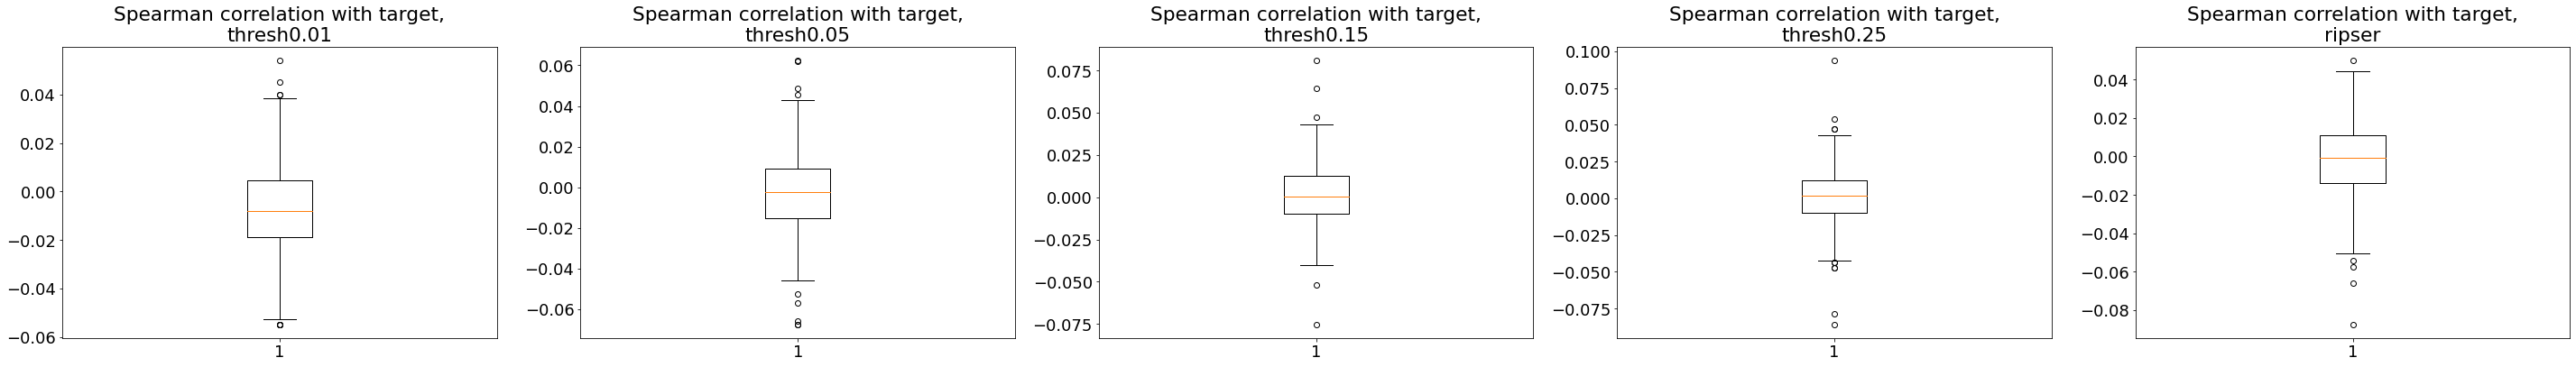

In [76]:
plt.figure(figsize=(len(FEAT_TYPES) * 8, 6))

for i, feat_type in enumerate(FEAT_TYPES):
    X_train, y_train = load_hades("train", feat_type)    
    X_train, = remove_redundant_columns(X_train)
    full_df = pd.concat([X_train, y_train], axis=1)

    corr_df = full_df.corr(method="spearman")["target"].drop("target")

    ax = plt.subplot(1, len(FEAT_TYPES), i + 1)
    plt.boxplot(corr_df)
    ax.set_title(f"Spearman correlation with target,\n{feat_type}")

plt.tight_layout()
plt.show()